# **AutoScout360**

### AutoScout24 Data: Car Price Prediction and Insights


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Business Understanding</p>

The goal of the project is to develop an intelligent recommendation system that provides used car buyers with personalized vehicle suggestions based on their specific needs and preferences. The system aims to accelerate the search for the right vehicle by recommending a selection of cars based on factors such as budget, mileage, drive type, transmission type, and model preferences.

By leveraging machine learning and data analysis, the system can help buyers find the optimal vehicle for them without having to navigate through countless listings. The goal is to streamline the entire buying process and increase customer satisfaction.

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Data Understanding</p>

In [ ]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Import data
data = pd.read_csv('autoscout24.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


In [7]:
data.isna().sum()

mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

First, in 'model' we have 143 NaN-values, in 'gear' we have 182 NaN-values and in 'hp' we have 29 NaN-values.
Second, we have a lot of string objects that we have to transform or to remove for our ML-model.
Third, we have 9 features and 46405 samples in our dataset.

In [8]:
# what about the statistics for numeric variables?
data.describe().round(0)

,mileage,price,hp,year
count,46405.0,46405.0,46376.0,46405.0
mean,71178.0,16572.0,133.0,2016.0
std,62625.0,19305.0,75.0,3.0
min,0.0,1100.0,1.0,2011.0
25%,19800.0,7490.0,86.0,2013.0
50%,60000.0,10999.0,116.0,2016.0
75%,105000.0,19490.0,150.0,2019.0
max,1111111.0,1199900.0,850.0,2021.0


In the columns 'mileage' and 'price', we observe a relatively high standard deviation. This suggests significant variability in the data, indicating a wide range of different cars in our dataset.

In the 'hp' (horsepower) column, we also see a notable range in the standard deviation, although it is not as large as in 'mileage' and 'price'. For 'year_registration', the standard deviation is 3 years, which indicates that most cars are clustered around a specific year, with some variation.

However, it seems that there are some incorrect values in the 'hp' column. For instance, the maximum value is 850 and the minimum value is 1. These values seem to be erroneous, as they are not realistic for car horsepower. However, the maximum price is $1,199,900.00, and a car with a horsepower of 850 might be realistic for this price. On the other hand, a horsepower of 1 is definitely too low.

The maximum mileage value of 1,111,111 miles seems to be incorrect. In my opinion, it would be rare to own a car that achieves a mileage of about 500,000 miles.


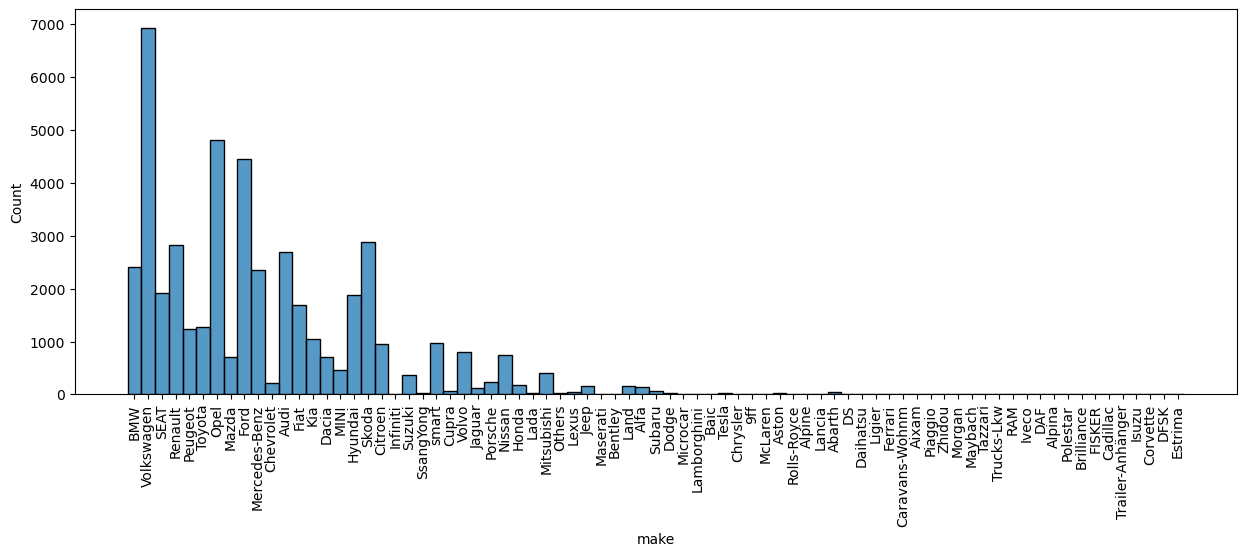

In [9]:
# what about the frequency of categorial variables?
list_brand_model_propulsion = data[['make','model','fuel']]

fig,ax = plt.subplots(figsize=(15,5))
sns.histplot(data=list_brand_model_propulsion, x='make')
ax.tick_params(axis='x', rotation=90)
plt.show()

C:\Users\mail\AppData\Local\Temp\ipykernel_18892\2068280339.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


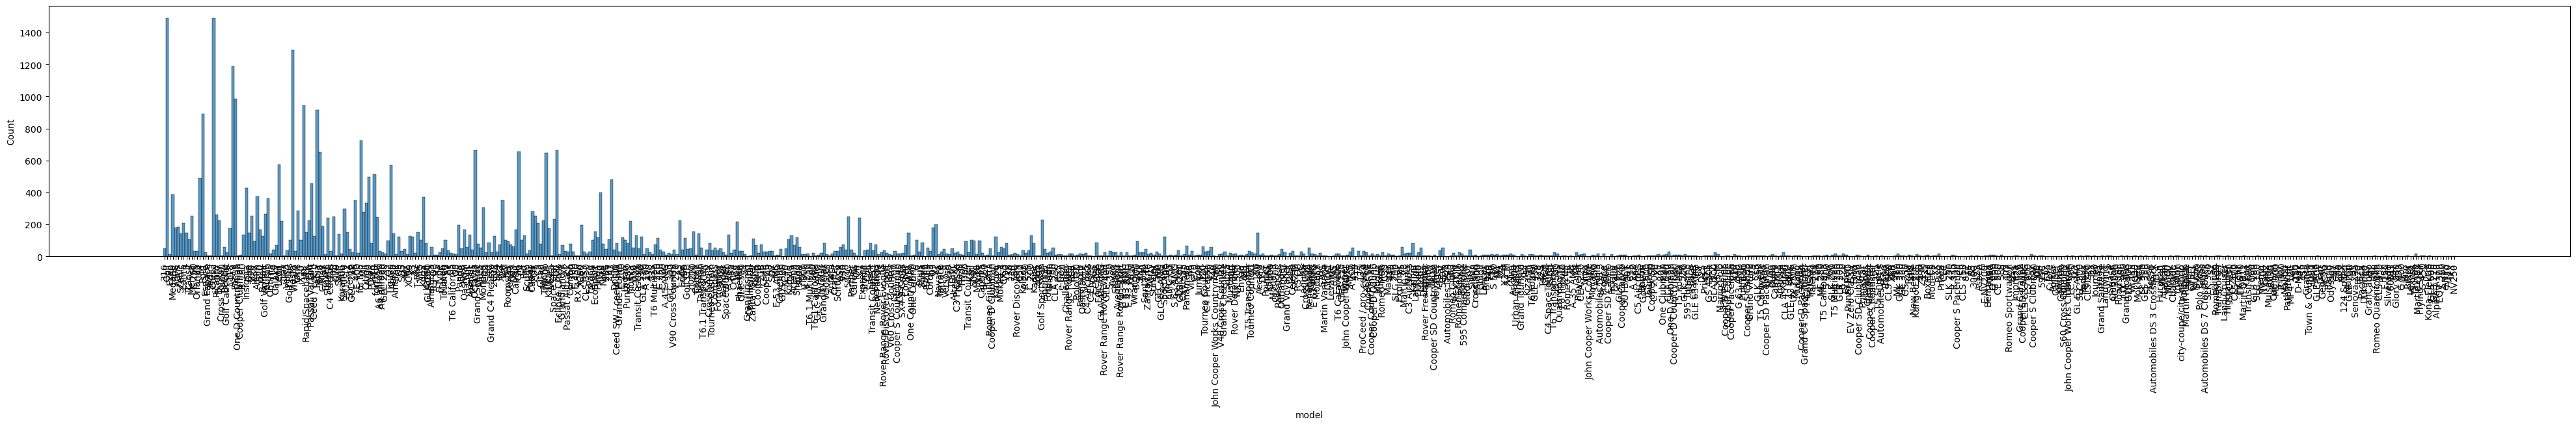

In [10]:
fig,ax = plt.subplots(figsize=(50,5))
sns.histplot(data=list_brand_model_propulsion, x='model')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

C:\Users\mail\AppData\Local\Temp\ipykernel_18892\1190448761.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


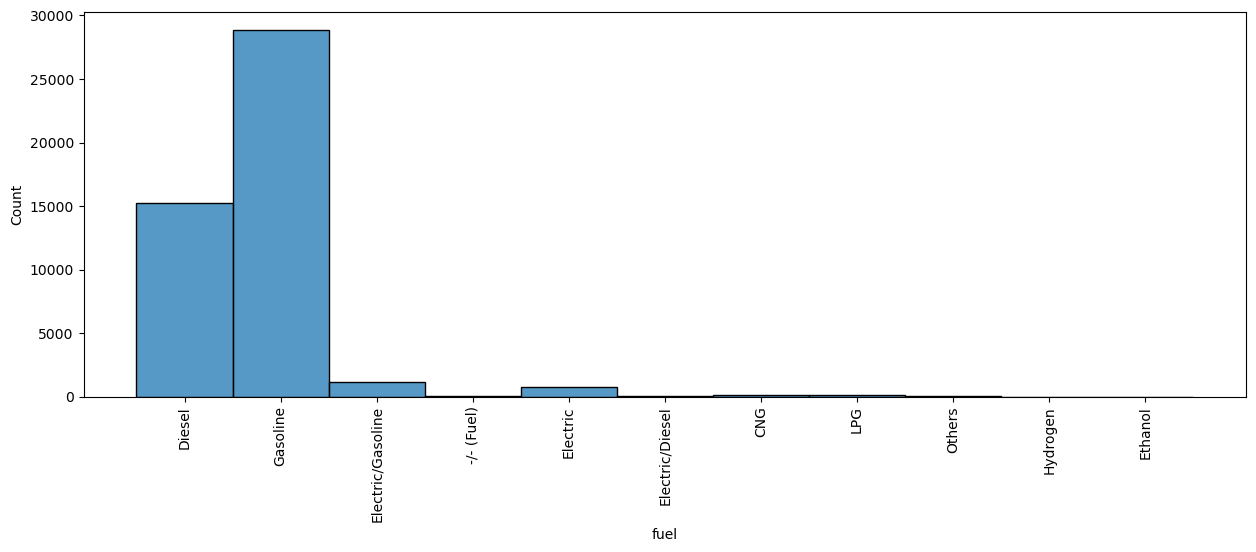

In [11]:
fig,ax = plt.subplots(figsize=(15,5))
sns.histplot(data=list_brand_model_propulsion, x='fuel')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The focus is on european cars with 'Diesel' and 'Gasoline'.

<Axes: >

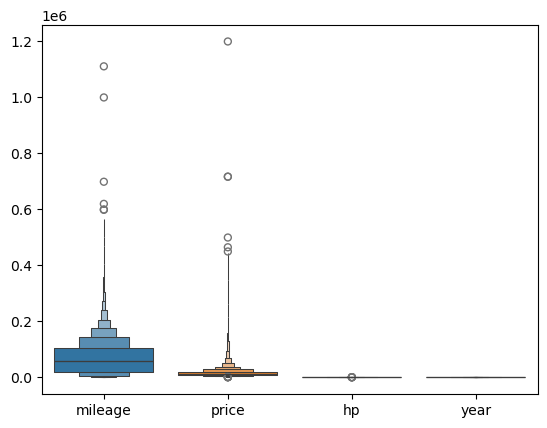

In [12]:
sns.boxenplot(data=data)

The numbers within the various features differ greatly in size. For this reason, we need to standardize the values before applying machine learning. After standardization, the means of the features will be 0 and the standard deviations will be 1. This ensures that the values are brought into comparable ranges, so that large numbers do not distort the analysis.

In [13]:
data[data['mileage']>600000]

,mileage,make,model,fuel,gear,offerType,price,hp,year
16869,1111111,Opel,Karl,Gasoline,Manual,Demonstration,10490,73.0,2019
25438,620000,Mercedes-Benz,Vito,Diesel,Manual,Used,6500,163.0,2014
34744,699000,Mercedes-Benz,Sprinter,Diesel,Manual,Used,3990,163.0,2011
38049,999999,BMW,320,-/- (Fuel),NaN,Used,1999,NaN,2014


There are 3 cars that are very expensive. We can conclude that these are genuine outliers in our dataset. So, we do not have to eliminate these outliers in our dataset. But there is a Opel Karl with a mileage over 1000000 miles. It seems to be an error that we have to fix.

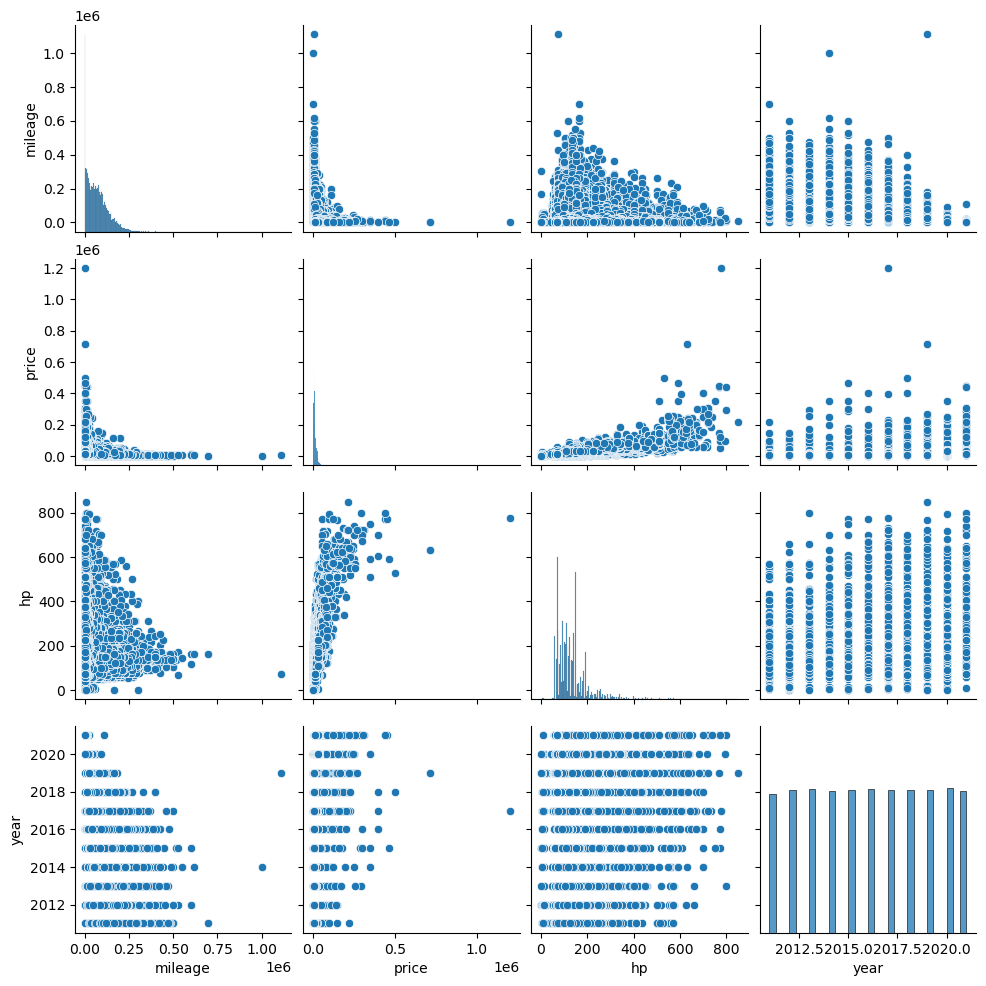

In [14]:
sns.pairplot(data=data)

In the pairplot, we can consider that 'hp', 'price', and 'mileage' have skewed distributions. 'Year_registration' is normally distributed.

Furthermore, we can see a strong correlation between 'price' and 'hp'.

<Axes: >

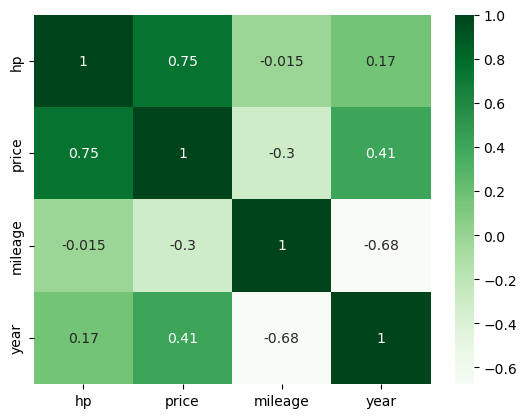

In [15]:
# Check correlations
numerical_features = ['hp', 'price','mileage','year']
sns.heatmap(data=data[numerical_features].corr(),annot=True, cmap='Greens')

You can consider very good correlations between:
- 'hp' and 'price'
- 'mileage' and 'year_registration'

You can consider good correlations between:
- 'year_registration' and 'price'
- 'price' and 'mileage'

Less strong correlations you can find between:
- 'year_registration' and 'hp'
- 'mileage' and 'hp'

Finally, we can say that this dataset is ideal for our project. We have a lot of samples and features and only a few NaN-values in our dataset. So, we can perform some data mining for our dashboard. Ideas for analysis could be:
- which car brand / car model has the highest mean in mileage (indicating best quality)?
- how the value of vehicles is influenced by the type of powertrain?
- how does the value of vehicles change over time, depending on mileage of car?
- how does the value of vehicles change over time, depending on year of registration?
- how the value of vehicles is influenced by horsepower?
- how the value of vehicles in autoscout24 is influenced by number of offers that are placed at the same time?

Furthermore we could consider correlations between some features. However, we have to do some data preparation:
- drop NaN-values
- drop outliers
- standardize numerical values

Due to skewed distributions some ML-Algorithms may have difficulties, eg. linear regression, SVM, KNN, Neural Networks. Random Forest or Gradient Boosting Machines may perform better. But we will check first.


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Data Preparation</p>

In [16]:
# Rename some columns for a better understanding:

# mileage -> mileage
# make -> car_brand
# model -> model
# fuel -> propulsion
# gear -> gear
# offerType -> offerType
# price -> price
# hp -> hp
# year -> year_registration

data.rename(columns={'make':'car_brand', 'fuel':'propulsion','year':'year_registration'},inplace=True)

In [17]:
# Lets drop NaN-values!
data.dropna(inplace=True)
# Now, we have 46071 samples to analyse.

In [18]:
#Lets drop an outlier in mileage!

# Opel Karl with mileage > 1000000 miles:
index_to_drop = data[(data['model'] == 'Karl') & (data['mileage'] > 1000000)].index
data.drop(index_to_drop,inplace=True)

In [19]:
# Look for outliers in hp -> Renault Megane with 1 hp!
data[data['hp']<50].sort_values(by='hp').head(30)

,mileage,car_brand,model,propulsion,gear,offerType,price,hp,year_registration
9110,167000,Renault,Megane,Diesel,Manual,Used,5450,1.0,2012
1985,21800,Microcar,Due,Diesel,Automatic,Used,8490,5.0,2017
30563,24000,Microcar,M.Go,Diesel,Automatic,Used,8200,5.0,2016
30006,10,Hyundai,Kona,Electric/Gasoline,Automatic,Pre-registered,29490,5.0,2020
37859,1200,Aixam,City,Electric,Automatic,Used,8500,5.0,2014
25859,15766,Microcar,M8,Diesel,Manual,Used,3900,5.0,2014
37903,57800,Ligier,JS 50,Diesel,Automatic,Used,8600,5.0,2014
38503,46750,Microcar,M.Go,Diesel,Automatic,Used,8500,5.0,2015
40321,44850,Microcar,M.Go,Diesel,Automatic,Used,8400,5.0,2016
34306,17413,Microcar,M.Go,Diesel,Automatic,Used,7990,5.0,2011


We have a lot microcars in our dataset that have a horsepower of 5 - 24. I did some research so I can say that these values are correct. For exmaple, Renault Twizy has only 11 hp. But Renault Megane has definetely more than 1 hp. This is definetly an error we have to fix.

In [20]:
# Drop Renault Megane with 1 hp
index_to_drop = data[data['hp'] == 1].index
data.drop(index_to_drop,inplace = True)

In [ ]:
# Export new dataset for analysis.py
#data.to_csv('cleaned_dataframe_for_analysis.csv')

In [21]:
#Standardize numerical features
numerical_features = ['mileage','price','hp', 'year_registration']
scaler = StandardScaler()
scaled_data = data[numerical_features]
scaled_data = scaler.fit_transform(data[numerical_features])

Okay, now, we have to focus on 5 manufacturers we want to focus on to train our model.

In [22]:
data['car_brand'].value_counts().sort_values(ascending=False)
# We choose 'Volkswagen', 'Opel', 'Ford', 'Skoda' and 'Renault' to train our model. Now, we consider 21770 Samples

car_brand
Volkswagen    6907
Opel          4788
Ford          4410
Skoda         2874
Renault       2791
              ... 
Isuzu            1
Others           1
Zhidou           1
Brilliance       1
Alpine           1
Name: count, Length: 71, dtype: int64

In [23]:
X_brands = data[(data['car_brand'] == 'Volkswagen') | (data['car_brand'] == 'Opel') | (data['car_brand'] == 'Ford') | (data['car_brand'] == 'Skoda') | (data['car_brand'] == 'Renault')]
X_brands

,mileage,car_brand,model,propulsion,gear,offerType,price,hp,year_registration
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
6,91894,Renault,Scenic,Diesel,Manual,Used,6970,131.0,2011
7,127500,Opel,Zafira,Gasoline,Manual,Used,6972,116.0,2011
9,104,Ford,Transit,Diesel,Manual,Used,6990,86.0,2011
...,...,...,...,...,...,...,...,...,...
46376,5000,Renault,Grand Scenic,Gasoline,Manual,Demonstration,32480,158.0,2021
46377,100,Volkswagen,Golf,Diesel,Automatic,Pre-registered,32490,150.0,2021
46379,6000,Renault,Kadjar,Gasoline,Manual,Demonstration,32680,158.0,2021
46381,4800,Volkswagen,T-Cross,Gasoline,Automatic,Demonstration,32880,150.0,2021


We have to use One-Hot-Encoding to transform categorial variables into numerical variables

In [24]:
# Create Dummie variables
X_bran_enc = pd.get_dummies(X_brands, columns=['car_brand','model', 'propulsion','gear','offerType'])


In [25]:
# Transform True and False in 1 and 0
X_bran_enc = X_bran_enc.astype(int)
X_bran_enc

,mileage,price,hp,year_registration,car_brand_Ford,car_brand_Opel,car_brand_Renault,car_brand_Skoda,car_brand_Volkswagen,model_Adam,...,propulsion_LPG,propulsion_Others,gear_Automatic,gear_Manual,gear_Semi-automatic,offerType_Demonstration,offerType_Employee's car,offerType_New,offerType_Pre-registered,offerType_Used
1,92800,6877,122,2011,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,96200,6950,110,2011,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,91894,6970,131,2011,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,127500,6972,116,2011,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,104,6990,86,2011,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46376,5000,32480,158,2021,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
46377,100,32490,150,2021,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
46379,6000,32680,158,2021,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
46381,4800,32880,150,2021,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


We have to split our data in: 
- training features and target features
- training and test data

In [26]:
# Split data in training features (X) and test feature (y)
y = X_bran_enc['price']
X = X_bran_enc.drop('price', axis=1)

In [27]:
# Split data in train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In my opinion, we are ready for modeling!  :)

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Modeling</p>

First, we have to choose our algorithm. We have to keep in mind that we have skewed distributions and we want to estimate a continuous variable. I would suggest to start with XGBoost, LightGBM, Linear Regression, Random Forest and Lasso. Lets see how it works!

Lets start with **LightGBM**:

In [28]:
# Create LightGBM-data objects
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test,label=y_test, reference=train_data)

# Define standard-params
params={
    'objective':'regression',
    'metric':'mse',
}

# Train model without tuned Hyperparameters 
start_train_lgbm = time.time()
model_lgb = lgb.train(params,train_data)
end_train_lgbm = time.time()
train_time_lgbm = end_train_lgbm - start_train_lgbm

# Predictions on X_test
start_pred_lgbm = time.time()
y_pred_lgb = model_lgb.predict(X_test)
end_pred_lgbm = time.time()
pred_time_lgbm = end_pred_lgbm - start_pred_lgbm

# Calculate MSE
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

# print MSE
print(f"Mean Squared Error (LightGBM): {mse_lgb:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 15239, number of used features: 100
[LightGBM] [Info] Start training from score 13447.384474
Mean Squared Error (LightGBM): 5792700.78


Lets continue with **XGBoost**:

In [29]:
# Train model without tuned Hyperparameters
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', eval_metric = 'rmse')
start_train_xgb = time.time()
model_xgb.fit(X_train,y_train)
end_train_xgb = time.time()
train_time_xgb = end_train_xgb - start_train_xgb

# Predictions on X_test
start_pred_xgb = time.time()
y_pred_xgb = model_xgb.predict(X_test)
end_pred_xgb = time.time()
pred_time_xgb = end_pred_xgb - start_pred_xgb

# Calculate MSE
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# print MSE
print(f"Mean Squared Error (XGBoost): {mse_xgb:.2f}")

Mean Squared Error (XGBoost): 4667449.57


We go on with **Linear Regression**:

In [30]:
# Train model without tuned Hyperparameters
model_linreg = LinearRegression()
start_train_linreg = time.time()
model_linreg.fit(X_train,y_train)
end_train_linreg = time.time()
train_time_linreg = end_train_linreg - start_train_linreg

# Predictions on X_test
start_pred_linreg = time.time()
y_pred_linreg = model_linreg.predict(X_test)
end_pred_linreg = time.time()
pred_time_linreg = end_pred_linreg - start_pred_linreg

# Calculate MSE
mse_linreg = mean_squared_error(y_test, y_pred_linreg)

# print MSE
print(f"Mean Squared Error (LinearRegression): {mse_linreg:.2f}")

Mean Squared Error (LinearRegression): 9557328.94


Now, lets try **Random Forest**:

In [31]:
# Train model without tuned Hyperparameters
model_rf = RandomForestRegressor()
start_train_rf = time.time()
model_rf.fit(X_train,y_train)
end_train_rf = time.time()
train_time_rf = end_train_rf - start_train_rf

# Predictions on X_test
start_pred_rf = time.time()
y_pred_rf = model_rf.predict(X_test)
end_pred_rf = time.time()
pred_time_rf = end_pred_rf - start_pred_rf

# Calculate MSE
mse_rf = mean_squared_error(y_test, y_pred_rf)

# print MSE
print(f"Mean Squared Error (Random Forest): {mse_rf:.2f}")

Mean Squared Error (Random Forest): 5194278.38


Last but not least, we try **Lasso**:

In [32]:
# Train model without tuned Hyperparameters
model_lasso = Lasso()
start_train_lasso = time.time()
model_lasso.fit(X_train,y_train)
end_train_lasso = time.time()
train_time_lasso = end_train_lasso - start_train_lasso

# Predictions on X_test
start_pred_lasso = time.time()
y_pred_lasso = model_lasso.predict(X_test)
end_pred_lasso = time.time()
pred_time_lasso = end_pred_lasso - start_pred_lasso

# Calculate MSE
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# print MSE
print(f"Mean Squared Error (Lasso): {mse_lasso:.2f}")

Mean Squared Error (Lasso): 9667323.54


Let's compare the performance of the models to select one:

In [33]:
# Create DataFrame
performances = pd.DataFrame(columns=['LightGBM','XGBoost','LinearRegression','RandomForest','Lasso'], index=['MSE', 'Speed training', 'Speed prediction'])

# Fill data into DataFrame
performances.loc['MSE','LightGBM'] = mse_lgb
performances.loc['MSE','XGBoost'] = mse_xgb
performances.loc['MSE','LinearRegression'] = mse_linreg
performances.loc['MSE','RandomForest'] = mse_rf
performances.loc['MSE','Lasso'] = mse_lasso

performances.loc['Speed training','LightGBM'] = train_time_lgbm
performances.loc['Speed training','XGBoost'] = train_time_xgb
performances.loc['Speed training','LinearRegression'] = train_time_linreg
performances.loc['Speed training','RandomForest'] = train_time_rf
performances.loc['Speed training','Lasso'] = train_time_lasso

performances.loc['Speed prediction','LightGBM'] = pred_time_lgbm
performances.loc['Speed prediction','XGBoost'] = pred_time_xgb
performances.loc['Speed prediction','LinearRegression'] = pred_time_linreg
performances.loc['Speed prediction','RandomForest'] = pred_time_rf
performances.loc['Speed prediction','Lasso'] = pred_time_lasso

In [34]:
# Show DataFrame
performances = performances.apply(pd.to_numeric,errors='coerce')
performances.round(2)

,LightGBM,XGBoost,LinearRegression,RandomForest,Lasso
MSE,5792700.78,4667449.57,9557328.94,5194278.38,9667323.54
Speed training,0.19,0.43,0.13,10.70,2.09
Speed prediction,0.01,0.09,0.00,0.15,0.01


We can see that XGBoost has a significantly better MSE compared to the other algorithms. Additionaly, the training and prediction times are very low across all models. Therefore, we will use XGBoost for our predictions.

Second, tuning of hyperparameters is a good idea to get better results!

In [35]:

# Define the hyperparameter space

param_grid = {
    'n_estimators':[50,100,200],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,5,7],
    'subsample':[0.7,0.8,1.0],
    'colsample_bytree':[0.7,0.8,1.0],
    'gamma':[0,0.1,0.2]
}
'''
# Use GridSearchCV

grid_search = GridSearchCV(estimator=model_xgb,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train,y_train)

# Show results
print(f"best hyperparameters: {grid_search.best_params_}")
print(f"best cross-validation score: {grid_search.best_score_}")

# use best model for predictions

tuned_model = grid_search.best_estimator_
'''

'\n# Use GridSearchCV\n\ngrid_search = GridSearchCV(estimator=model_xgb,\n                           param_grid=param_grid,\n                           scoring=\'neg_mean_squared_error\',\n                           cv=5,\n                           verbose=1,\n                           n_jobs=-1)\ngrid_search.fit(X_train,y_train)\n\n# Show results\nprint(f"best hyperparameters: {grid_search.best_params_}")\nprint(f"best cross-validation score: {grid_search.best_score_}")\n\n# use best model for predictions\n\ntuned_model = grid_search.best_estimator_\n'

Now that we have a tuned model for our predictions, the next step is to predict our target and evaluate our error metrics.

In [ ]:

# Definiere das Modell mit Parametern
tuned_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    gamma=10,
    learning_rate=0.2,
    max_depth=4,
    n_estimators=300,
    subsample=1,
    reg_lambda=20,
    reg_alpha=100
)

# Trainiere das Modell
tuned_model.fit(X_train, y_train)


# Vorhersagen für das Training-Set
y_train_pred = tuned_model.predict(X_train)

# Vorhersagen für das Test-Set
y_pred = tuned_model.predict(X_test)

Evaluation Results:

Train: MAE: 1318.29, MSE: 4355894.04, RMSE: 2087.08, R²: 0.95

Test:  MAE: 1418.57, MSE: 5095652.53, RMSE: 2257.36, R²: 0.95

The model seems to be well-balanced.


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Evaluation</p>

Now, we have to evaluate our tuned model. We should calculate MAE, MSE, RMSE, R2 on trainings and on test data to evaluate over- and underfitting. 

In [96]:
# Berechne MAE, MSE, RMSE und R² für das Trainingsset
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Berechne MAE, MSE, RMSE und R² für das Testset
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)

# Ausgabe der Ergebnisse zur Evaluierung
print("Evaluation Results:\n")
print(f"{'Train:':5} MAE: {mae_train:5.2f}, MSE: {mse_train:5.2f}, RMSE: {rmse_train:6.2f}, R²: {r2_train:3.2f}\n")
print(f"{'Test:':6} MAE: {mae_test:5.2f}, MSE: {mse_test:5.2f}, RMSE: {rmse_test:5.2f}, R²: {r2_test:3.2f}")

# Überprüfung auf Over- / Underfitting
if rmse_test > rmse_train and (rmse_test - rmse_train) > 0.1 * rmse_train:
    print('\nWarning: Potential overfitting. Test RMSE is significantly higher than Train RMSE.')

elif rmse_train > rmse_test:
    print('\nWarning: Potential underfitting. Train RMSE is high.')

else:
    print('\nThe model seems to be well-balanced.')

Evaluation Results:

Train: MAE: 1318.29, MSE: 4355894.04, RMSE: 2087.08, R²: 0.95

Test:  MAE: 1418.57, MSE: 5095652.53, RMSE: 2257.36, R²: 0.95

The model seems to be well-balanced.


Now, we have a well-balanced tuned_model to predict our prices with a R2-score of 95%! This means our model can explain 95% of the variation in the price data.

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Deployment</p>

For this step, I create a dashboard in Tableau and a streamlit app. The streamlit app will include the dashboard, tuned_model and further analysis. For Streamlit I created some Python-files that you can find in Repository.